In [10]:
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
!wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Challenge/ABCBiomass/
!pwd

/content/drive/MyDrive/Challenge/ABCBiomass
/content/drive/MyDrive/Challenge/ABCBiomass


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
# import torchvision.models as models
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [4]:
from abcdataset import get_h5_images
from abcdataset import ABCDataset
from visualization import ShowBandsCombination, plot_spatial, scatter_spectrums,plot_spectrum, scatter_spectrum
from abctrain import evaluate_conv_deconv, evaluate_predict, evaluate_model, train_conv_deconv, train_predict, train_model
from model import ConvEncoder, DeConvDecoder, myNet

### models


In [17]:

class ConvEncoder1(nn.Module):
  """ create convolutional layers to extract features
  from input multipe spectral images
  
  Attributes:
  data : input data to be encoded
  """

  def __init__(self, in_channel):
      super(ConvEncoder1,self).__init__()
      #Convolution 1
      self.conv1=nn.Conv2d(in_channels=in_channel,out_channels=128, kernel_size=7, stride=2, padding = 3)   # padding='valid', there's no padding; padding='same' the input are zero-padded
      # nn.init.xavier_uniform(self.conv2.weight)

      #Convolution 2
      self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding='same')
      
      #Convolution 3
      self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
      self.bn3 = nn.BatchNorm2d(128)

      #Convolution 4      
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, padding='same')
      self.bn4 = nn.BatchNorm2d(256)

      #Convolution 5      
      self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding='same')
      self.bn4 = nn.BatchNorm2d(512)

      # activation function
      self.relu= nn.ReLU()

      #Max Pool 1
      self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)

      #Average Pool 1
      # self.averagepool = nn.AvgPool2d(kernel_size=2,return_indices=True)
      # self.maxpool1= nn.MaxPool2d(kernel_size=2,return_indices=True)

  def forward(self,x):

      pool_info = []

      out=self.relu(self.conv1(x))
      # out=self.relu(self.conv2(out))
      # out=self.bn3(out)

      # size1 = out.size()
      # out,indices1=self.maxpool(out)
      # pool_info.append([indices1,size1])

      out=self.relu(self.conv3(out))
      out=self.relu(self.conv4(out))
      # out=self.bn4(out)
      
      # size2 = out.size()
      # out,indices2=self.maxpool(out)
      # pool_info.append([indices2,size2])

      # out=self.conv5(out)

      return(out, pool_info)

In [18]:

class DeConvDecoder1(nn.Module):
  """ 
  reconstruct image from extracted features
  
  Attributes:
  features : input data to be encoded
  in_channel: reconstructed channels
  """
  def __init__(self, in_channel):
      super(DeConvDecoder1,self).__init__()

      #De Convolution 1
      self.deconv1=nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=1)
      # nn.init.xavier_uniform(self.deconv1.weight)
      # self.swish4=nn.ReLU()
      self.bn1 = nn.BatchNorm2d(512)

      #De Convolution 2
      self.deconv2=nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=1)
      self.bn2 = nn.BatchNorm2d(256)

      #De Convolution 3
      self.deconv3=nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3, padding = 1)
      self.bn3 = nn.BatchNorm2d(128)

      #De Convolution 4
      self.deconv4=nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=1)
      self.bn4 = nn.BatchNorm2d(128)

      #DeConvolution 5
      self.deconv5=nn.ConvTranspose2d(in_channels=128,out_channels=in_channel,kernel_size=7, stride=2, padding = 3)
      # nn.init.xavier_uniform(self.deconv3.weight)
      # self.swish6=nn.ReLU()

      # activation function
      self.relu= nn.ReLU()

      #Max UnPool 1
      self.maxunpool=nn.MaxUnpool2d(kernel_size=2)
      #Max UnPool 2
      # self.maxunpool2=nn.MaxUnpool2d(kernel_size=2)


  def forward(self,x, pool_info):

      # out=self.relu(self.deconv1(x))

      # indices2,size2 = pool_info[1]
      # # out=self.maxunpool(x)
      # out=self.maxunpool(x,indices2,size2)

      out=self.relu(self.deconv2(x))
      out=self.relu(self.deconv3(out))
      # out=self.bn3(out)

      # indices1,size1 = pool_info[0]
      # # out=self.maxunpool(out)
      # out=self.maxunpool(out,indices1,size1)
      
      # out=self.relu(self.deconv4(out))
      out=self.deconv5(out)
      # out=self.swish6(out)

      return(out)

In [8]:
class FFPredictNN(nn.Module):
    def __init__(self, input_size, hidden_size=0, num_classes=0):
        super(FFPredictNN, self).__init__()
        # self.fc1 = nn.Linear(input_size, 8*input_size)
        # self.relu = nn.ReLU()
        # # self.fc2 = nn.Linear(8*input_size, 8*input_size)
        # self.fc3 = nn.Linear(8*input_size, 4096)
        # self.fc4 = nn.Linear(4096, 1024)
        # self.fc5 = nn.Linear(1024, 1)
        self.fc1 = nn.Linear(input_size, 4098)
        self.fc2 = nn.Linear(4098, 1028)
        self.fc3 = nn.Linear(1028, 1)
    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class myNet(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        #self.conv1 = nn.Conv2d(in_channel, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = nn.Conv2d(in_channel,64, kernel_size=5, stride=1, padding=0, bias=False)
        self.conv2 = nn.Conv2d(64,128, kernel_size=5, stride=1, padding=0, bias=False)
        self.conv3 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=0, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*7*7, 4098)
        self.fc2 = nn.Linear(4098, 1028)
        self.fc3 = nn.Linear(1028, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class myNet2(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        #self.conv1 = nn.Conv2d(in_channel, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = nn.Conv2d(in_channel,128, kernel_size=3, stride=1, padding="same", bias=False)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2, bias=False)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, bias=False)
        # self.conv3 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*7*7, 4098)
        self.fc2 = nn.Linear(4098, 1028)
        self.fc3 = nn.Linear(1028, 1)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class EncoderDecoder(nn.Module):
  """ create convolutional layers to extract features
  from input multipe spectral images
  
  Attributes:
  data : input data to be encoded
  """

  def __init__(self, in_channel):
      super(EncoderDecoder,self).__init__()
      #Convolution 1
      self.conv1=nn.Conv2d(in_channels=in_channel,out_channels=128, kernel_size=7, stride=2, padding = 3)   # padding='valid', there's no padding; padding='same' the input are zero-padded
      # nn.init.xavier_uniform(self.conv2.weight)
      self.relu= nn.ReLU()
      #Convolution 2
      self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding='same')

      #Max Pool 1
      self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)

      #Convolution 3
      self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same')

      #Convolution 4      
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, padding='same')

      #Average Pool 1
      # self.averagepool = nn.AvgPool2d(kernel_size=2,return_indices=True)
      # self.maxpool1= nn.MaxPool2d(kernel_size=2,return_indices=True)

      #Convolution 5      
      self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding='same')

      
      #De Convolution 5
      self.deconv5=nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=1)
      # nn.init.xavier_uniform(self.deconv1.weight)
      # self.swish4=nn.ReLU()
      #Max UnPool 1
      self.maxunpool=nn.MaxUnpool2d(kernel_size=2)

      #De Convolution 4
      self.deconv4=nn.ConvTranspose2d(in_channels=512,out_channels=128,kernel_size=1)

      #De Convolution 3
      self.deconv3=nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3, padding = 1)

      #Max UnPool 2
      # self.maxunpool2=nn.MaxUnpool2d(kernel_size=2)

      #De Convolution 2
      self.deconv2=nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=1)

      #DeConvolution 1
      self.deconv1=nn.ConvTranspose2d(in_channels=128,out_channels=in_channel,kernel_size=7, stride=2, padding = 3)
      # nn.init.xavier_uniform(self.deconv3.weight)
      # self.swish6=nn.ReLU()
      
      
  def forward(self,x):
      # pool_info = []
      out=self.relu(self.conv1(x))
      # out,indices1=self.maxpool(out)
      out=self.relu(self.conv2(out))
      size1 = out.size()
      out,indices1=self.maxpool(out)
      # pool_info.append([indices1,size1])
      # out,indices2=self.maxpool(out)
      out=self.relu(self.conv3(out))
      out=self.relu(self.conv4(out))
      # out,indices2=self.averagepool(out)
      size2 = out.size()
      out,indices2=self.maxpool(out)
      
      # pool_info.append([indices2,size2])
      # out=self.conv5(out)
      # print(pool_info)
        # out=self.relu(self.deconv5(x))
      # indices2,size2 = pool_info[1]
      # out=self.maxunpool(x)
      out=self.maxunpool(out,indices2)
      out=self.relu(self.deconv4(out))
      out=self.relu(self.deconv3(out))
      # indices1,size1 = pool_info[0]
      # out=self.maxunpool(out)
      out=self.maxunpool(out,indices1)
      # out=self.maxunpool2(out,indices1,size1)
      out=self.relu(self.deconv2(out))
      out=self.deconv1(out)
      # out=self.swish6(out)
      return(out)

### dataset

In [9]:

# <KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>
keys = ['agbd', 'images', 'cloud', 'lat', 'lon', 'scl']
data_type = np.float64
cat_vi = True
cat_cloud = True
cat_coord = True
cat_scl = True

train_file = "09072022_1154_train.h5"
validate_file = "09072022_1154_val.h5"
test_file = "09072022_1154_test.h5"

train_biomasses, train_images = get_h5_images(train_file, keys, data_type, cat_vi, cat_cloud, cat_coord, cat_scl)
validate_biomasses,validate_images = get_h5_images(validate_file, keys, data_type, cat_vi, cat_cloud, cat_coord, cat_scl)
test_biomasses,test_images = get_h5_images(test_file, keys, data_type, cat_vi, cat_cloud, cat_coord, cat_scl)

In [10]:
max = train_images.max((0,2,3))
min = train_images.min((0,2,3))

In [11]:
# showimage = ShowBandsCombination(train_images[0:8,1:11,:], train_biomasses[0:8], [max,0])
# showimage.imshow_all_single()
# showimage.imshow_selectBands_3bands([2,3,4,5,6,7])
# showimage.imshow_selectBands_3bands([[3,2,1],[7,3,2],[7,6,3],[9,8,6]])
# imshow_chw(train_images[233,0:11,:])

In [12]:
# plot_spatial(train_images[0:2,:], train_biomasses[0:2])

In [13]:
validate_biomasses2 = np.log(validate_biomasses)
train_biomasses2 = np.maximum(np.log(train_biomasses),0)
test_biomasses2 = np.log(test_biomasses)

In [14]:
validate_biomasses1 = validate_biomasses/500
train_biomasses1 = np.minimum(train_biomasses/500,1)
test_biomasses1 = test_biomasses/500

In [15]:
train_test = train_images[:,0:15, :,:]
validate_test = validate_images[:,0:15,:,:]
test_test = test_images[:,0:15,:,:]


mean = train_test.mean((0,2,3))
std = train_test.std((0,2,3))

# Load and preprocess your data as required

batch_size = 24

train_dataset = ABCDataset(train_test, train_biomasses1, mean, std)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validate_dataset = ABCDataset(validate_test, validate_biomasses1, mean, std)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_dataset = ABCDataset(test_test, test_biomasses1, mean, std)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### train conv-deconv model

In [19]:
from torchsummary import summary

in_channel = train_test.shape[1]


conv = ConvEncoder1(in_channel)
summary(conv, (15, 15, 15))
deconv = DeConvDecoder1(in_channel)
# summary(deconv, (512, 2, 2))
# conv_deconv = EncoderDecoder(in_channel)
# summary(conv_deconv, (10, 15, 15))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]          94,208
              ReLU-2            [-1, 128, 8, 8]               0
            Conv2d-3            [-1, 128, 8, 8]         147,584
              ReLU-4            [-1, 128, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]          33,024
              ReLU-6            [-1, 256, 8, 8]               0
Total params: 274,816
Trainable params: 274,816
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.50
Params size (MB): 1.05
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [20]:

criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.Adam(list(conv.parameters()) + list(deconv.parameters()), lr=0.001)  # Adam optimizer
# optimizer = optim.Adam(conv.parameters().parameters(), lr=0.001)  # Adam optimizer

/content/drive/MyDrive/Challenge/ABCBiomass


In [21]:
num_epochs = 5
train_conv_deconv(conv, deconv, train_loader, validate_loader, criterion, optimizer, num_epochs)


[1,   100] loss: 1.787
[1,   200] loss: 0.180
[1,   300] loss: 0.119
[1,   400] loss: 0.079
[1,   500] loss: 0.063
[1,   600] loss: 0.050
[1,   700] loss: 0.042
[1,   800] loss: 0.039
[1,   900] loss: 0.035
[1,  1000] loss: 0.127
the training loss is 2.5221288190368796, the validation loss is 0.010278584435582161
[2,   100] loss: 0.084
[2,   200] loss: 0.033
[2,   300] loss: 0.029
[2,   400] loss: 0.032
[2,   500] loss: 0.027
[2,   600] loss: 0.027
[2,   700] loss: 0.029
[2,   800] loss: 0.030
[2,   900] loss: 0.026
[2,  1000] loss: 0.022
the training loss is 0.33975924795959145, the validation loss is 0.00684899277985096
[3,   100] loss: 0.022
[3,   200] loss: 0.092
[3,   300] loss: 0.033
[3,   400] loss: 0.024
[3,   500] loss: 0.049
[3,   600] loss: 0.023
[3,   700] loss: 0.021
[3,   800] loss: 0.021
[3,   900] loss: 0.019
[3,  1000] loss: 0.018
the training loss is 0.32252300408435985, the validation loss is 0.008247834630310535
[4,   100] loss: 0.030
[4,   200] loss: 0.026
[4,   30

### Predict using CONV features

In [22]:

batch_size = 64

train_dataset = ABCDataset(train_test, train_biomasses1, mean, std)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validate_dataset = ABCDataset(validate_test, validate_biomasses1, mean, std)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_dataset = ABCDataset(test_test, test_biomasses1, mean, std)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [23]:
feature_size = 256*8*8
predeict_net = FFPredictNN(feature_size)

criterion2 = nn.MSELoss()  # Mean Squared Error loss function
optimizer2 = optim.SGD(predeict_net.parameters(), lr=0.0001)
# optimizer2 = optim.Adam(predeict_net.parameters(), lr=0.0005)  # Adam optimizer
# optimizer = optim.SGD(list(conv.parameters()) + list(deconv.parameters()), lr=0.0005, momentum=0.9)


In [25]:
summary(predeict_net, (256, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4098]      67,145,730
            Linear-2                 [-1, 1028]       4,213,772
            Linear-3                    [-1, 1]           1,029
Total params: 71,360,531
Trainable params: 71,360,531
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.04
Params size (MB): 272.22
Estimated Total Size (MB): 272.32
----------------------------------------------------------------


In [ ]:
num_epochs = 50

train_predict(conv, predeict_net,  criterion2, optimizer2, train_loader, validate_loader, num_epochs, 500)

[1,   100] loss: 1.254
[1,   200] loss: 1.247
[1,   300] loss: 1.297
Average test loss: 4127.193
the training loss is 3.798186965752393, the validation loss is 21354094.44482422
[2,   100] loss: 1.395
[2,   200] loss: 1.163
[2,   300] loss: 1.185
Average test loss: 4124.391
the training loss is 3.7426672745496035, the validation loss is 21339601.443847656
[3,   100] loss: 1.251
[3,   200] loss: 1.256
[3,   300] loss: 1.186
Average test loss: 4122.365
the training loss is 3.6925353845581412, the validation loss is 21329118.09741211
[4,   100] loss: 1.228
[4,   200] loss: 1.209
[4,   300] loss: 1.318
Average test loss: 4120.908
the training loss is 3.755695766536519, the validation loss is 21321578.62158203
[5,   100] loss: 1.308
[5,   200] loss: 1.201
[5,   300] loss: 1.288
Average test loss: 4119.797
the training loss is 3.7959902693983167, the validation loss is 21315831.587646484
[6,   100] loss: 1.276
[6,   200] loss: 1.245
[6,   300] loss: 1.244
Average test loss: 4118.910
the trai

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-a83b0c1e07ff>", line 3, in <cell line: 3>
    train_predict(conv, predeict_net,  criterion2, optimizer2, train_loader, validate_loader, num_epochs, 500)
  File "/content/drive/MyDrive/Challenge/ABCBiomass/abctrain.py", line 146, in train_predict
    loss.backward()
  File "/usr/local/lib/python3.9/dist-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.

In [28]:
evaluate_predict(predeict_net, conv, test_loader,criterion2, 500)


Average test loss: 4307.430


22355561.322875977

### CNN model


In [ ]:
# Load and preprocess your data as required

batch_size = 64

train_dataset = ABCDataset(train_test, train_biomasses, mean, std)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validate_dataset = ABCDataset(validate_test, validate_biomasses, mean, std)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_dataset = ABCDataset(test_test, test_biomasses, mean, std)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:

in_channel = train_test.shape[1]
# Define the model, loss function and optimizer
# model = ResNet34_R(in_channel)
model = myNet(in_channel)
# model = Net(in_channel)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.0001)

# optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0,)

In [ ]:
train_model(model,  criterion, optimizer, train_loader, validate_loader, num_epochs, 1)

### Visualization

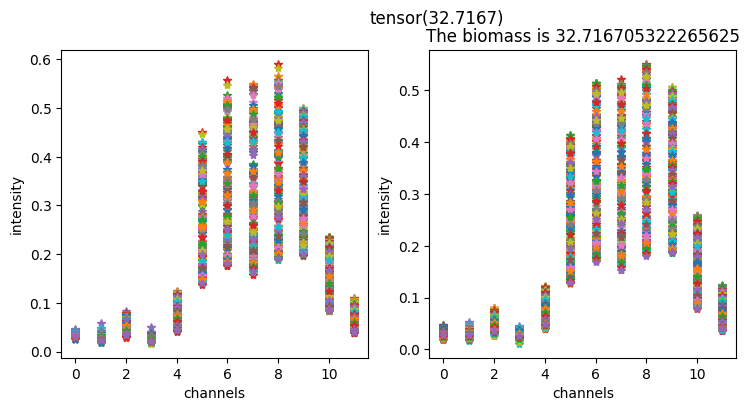

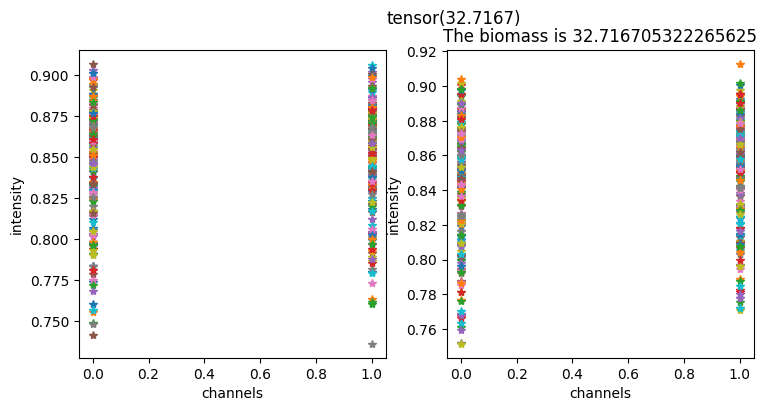

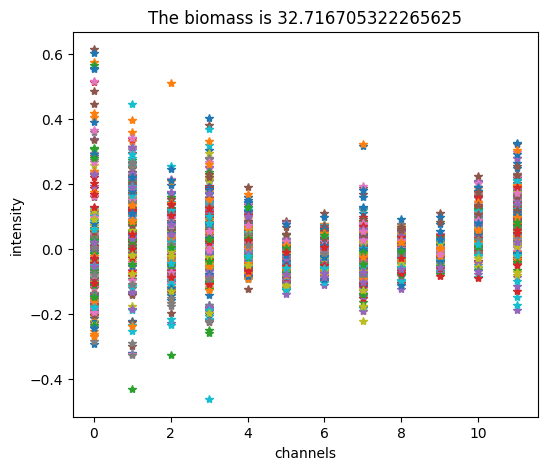

0.4362625


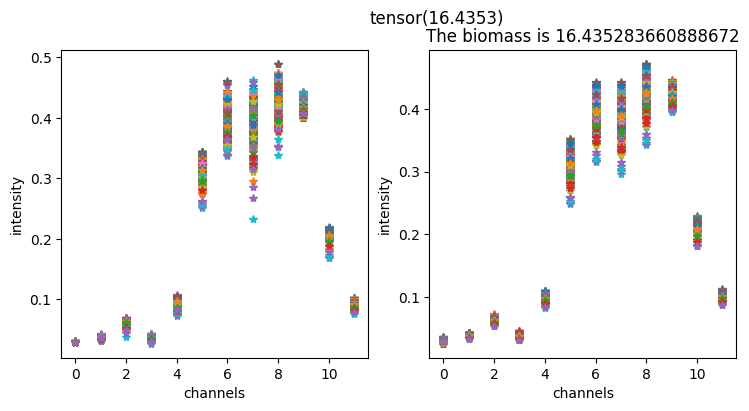

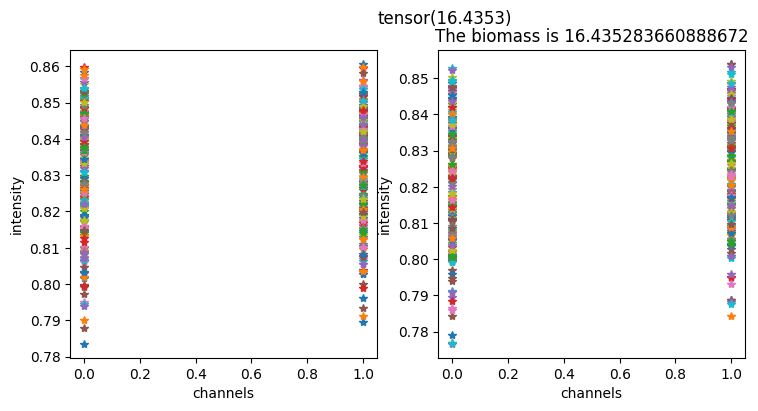

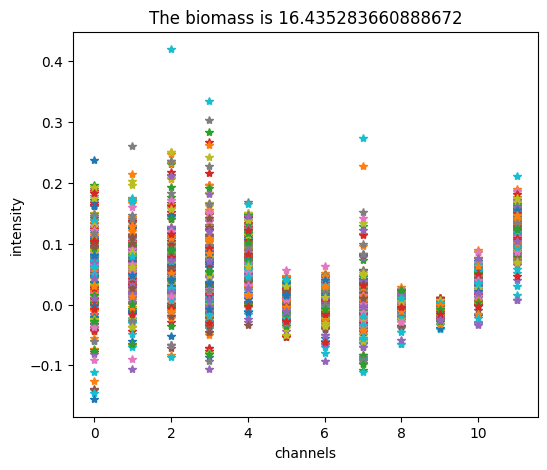

0.19053647


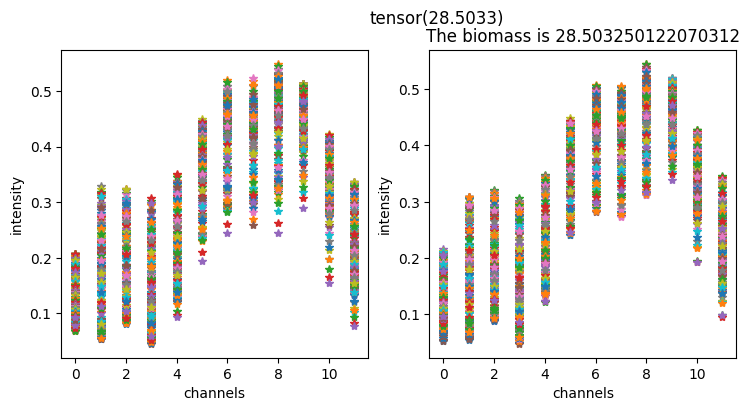

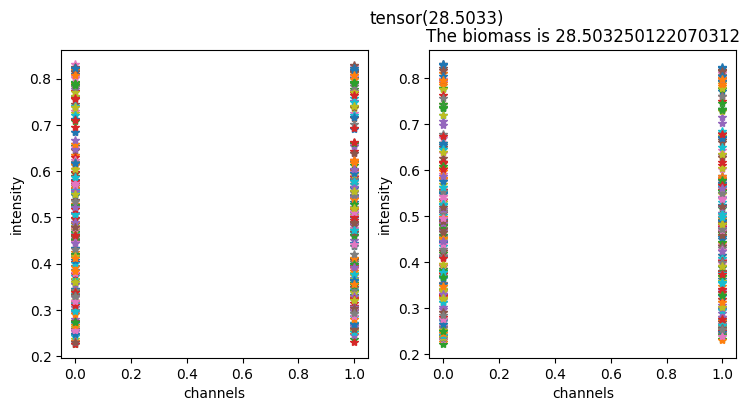

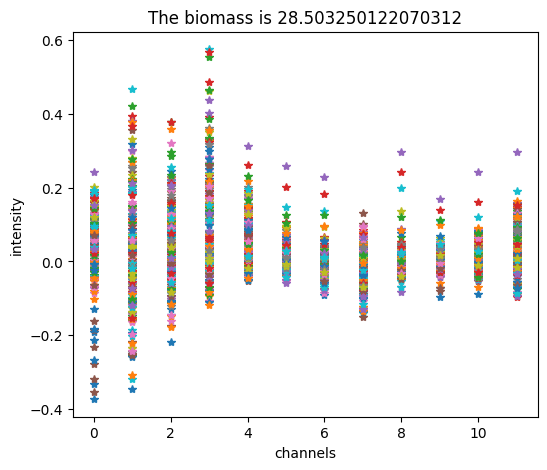

0.73882717


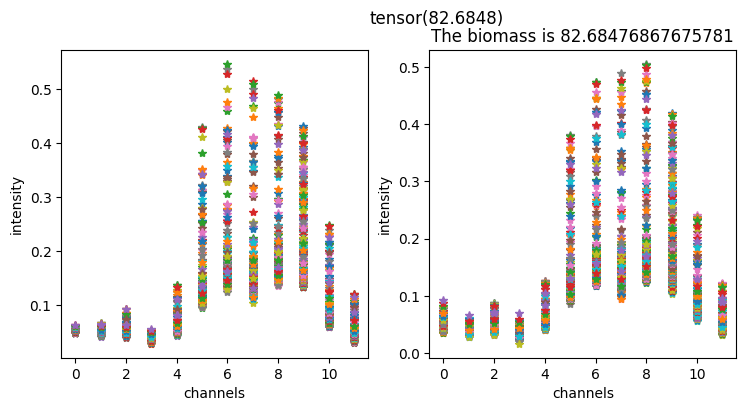

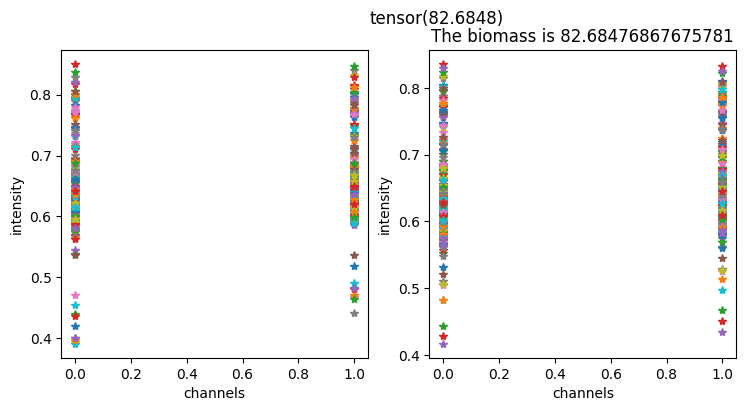

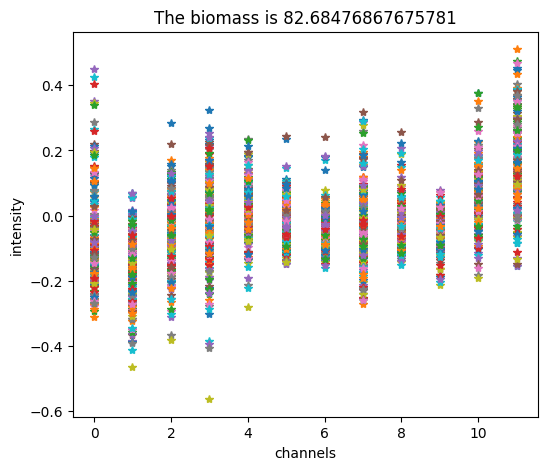

0.42446044


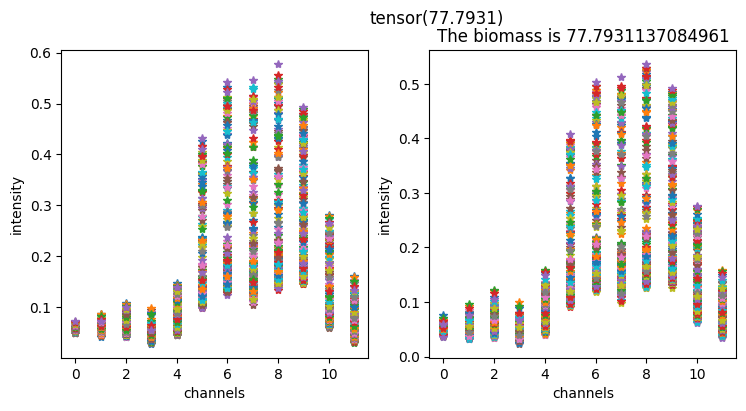

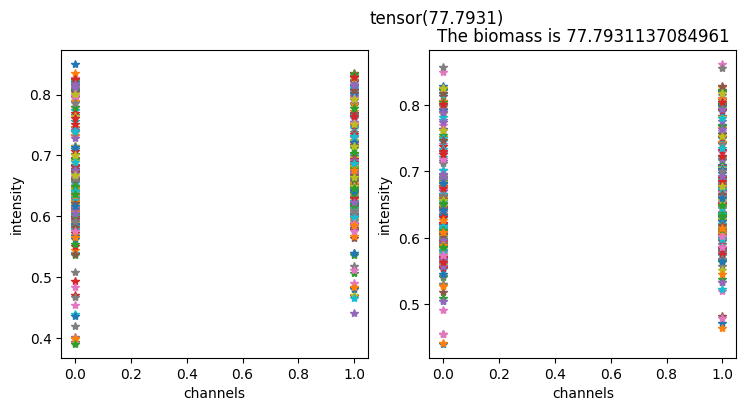

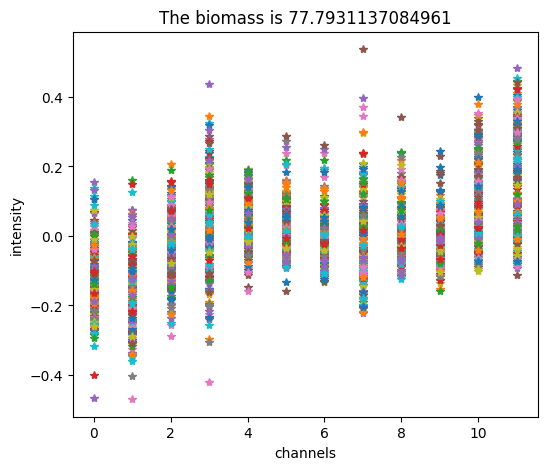

0.568813


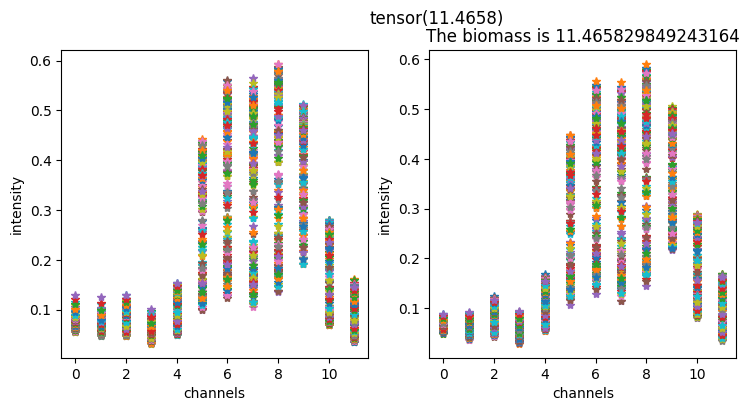

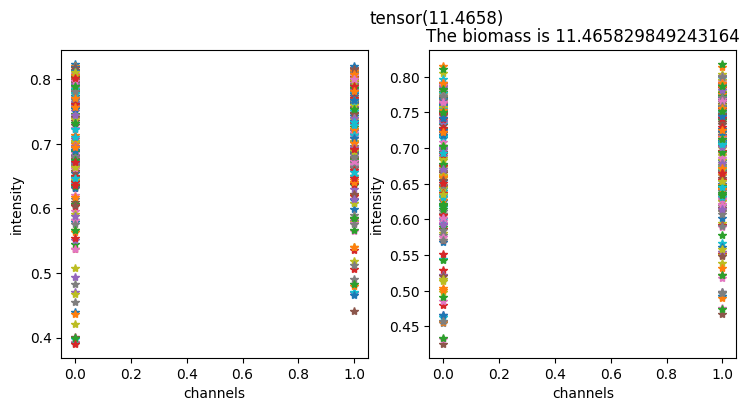

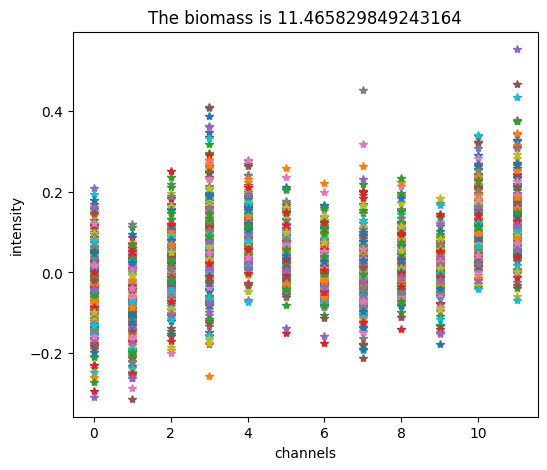

0.6756996


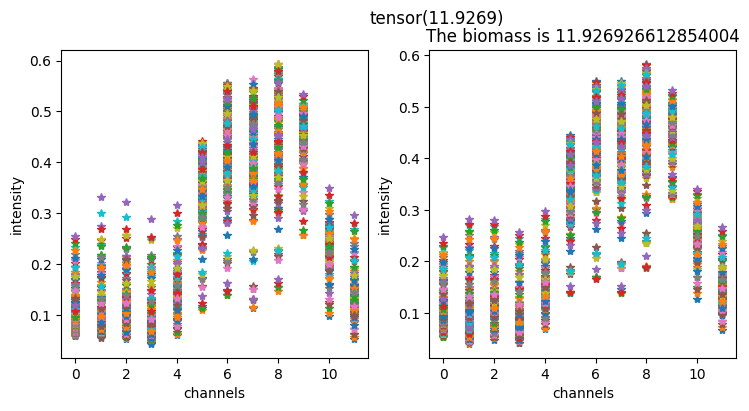

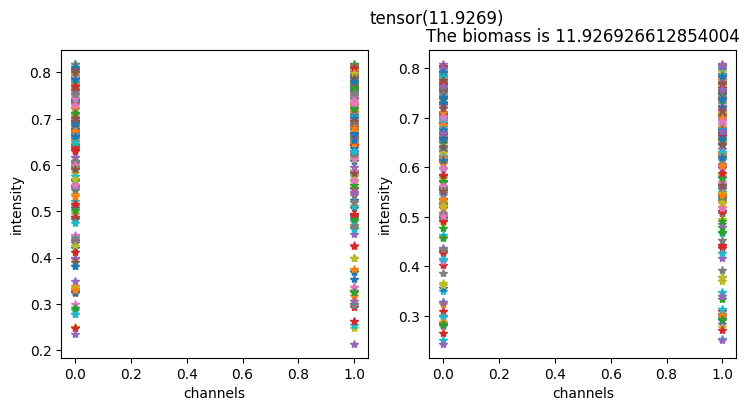

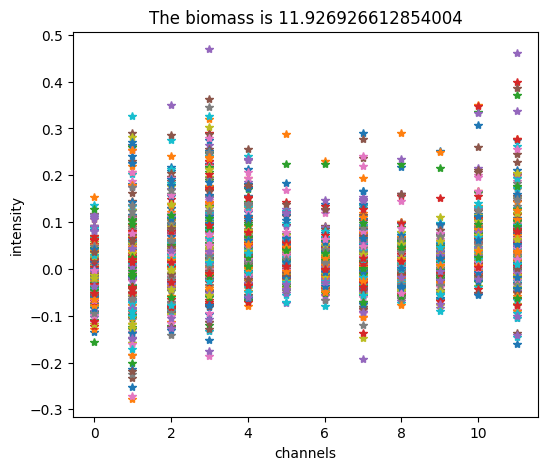

0.6300858


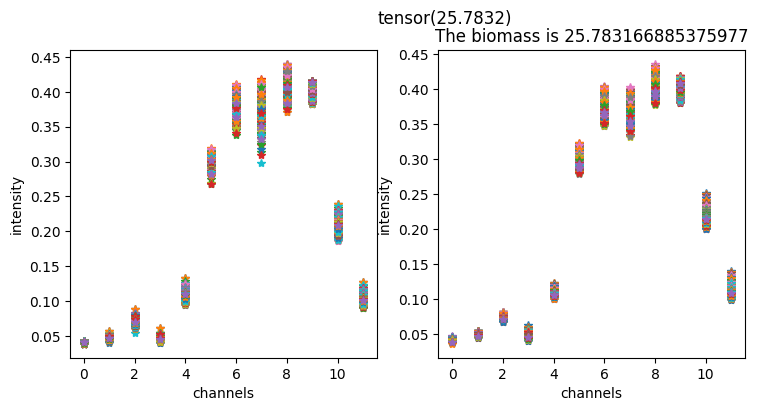

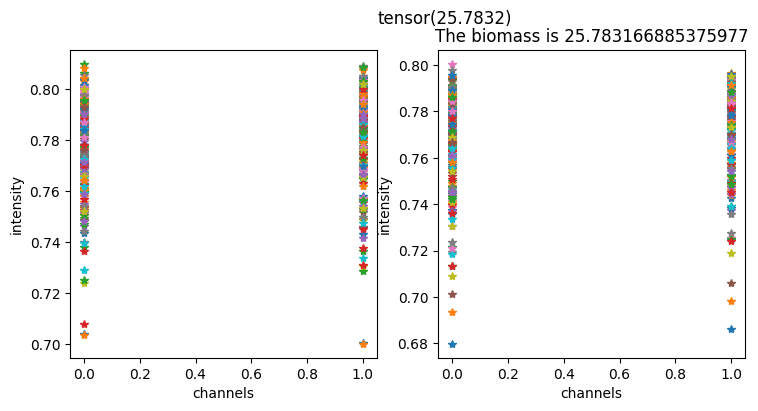

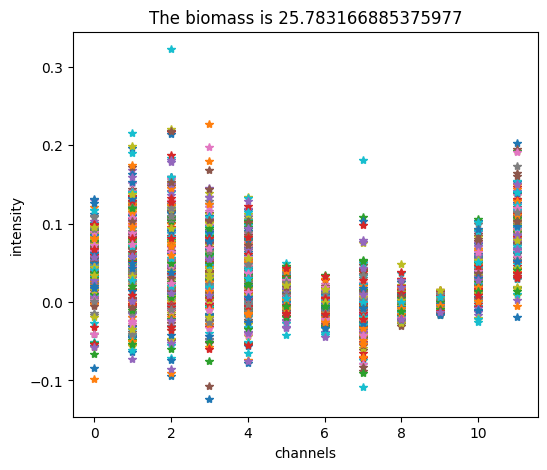

0.1364773


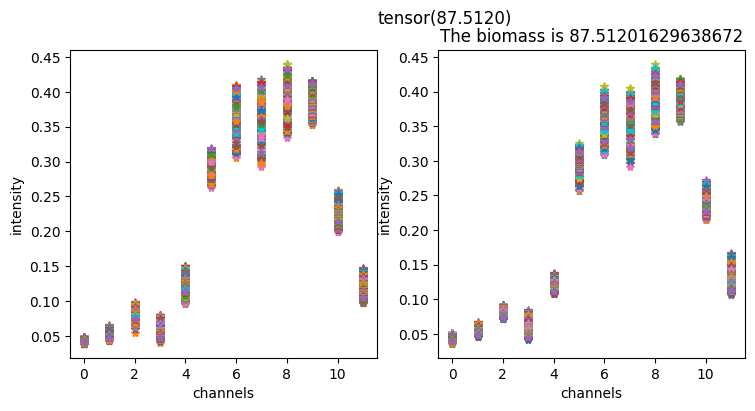

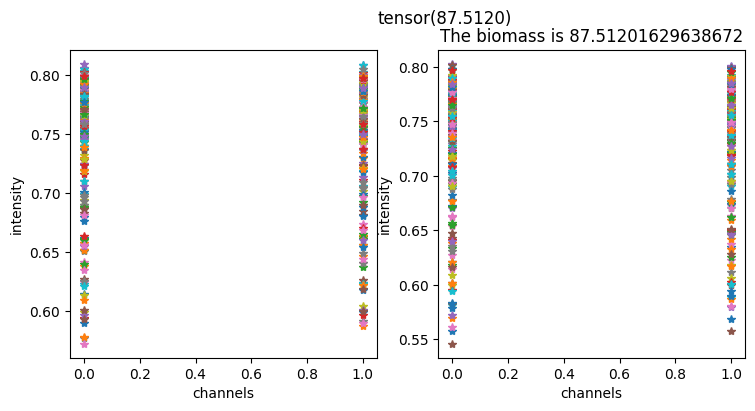

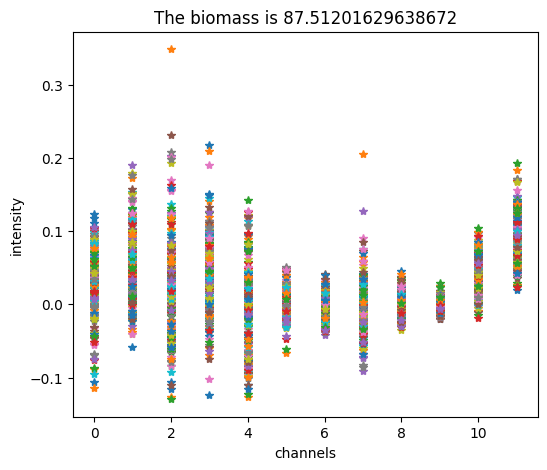

0.14670163


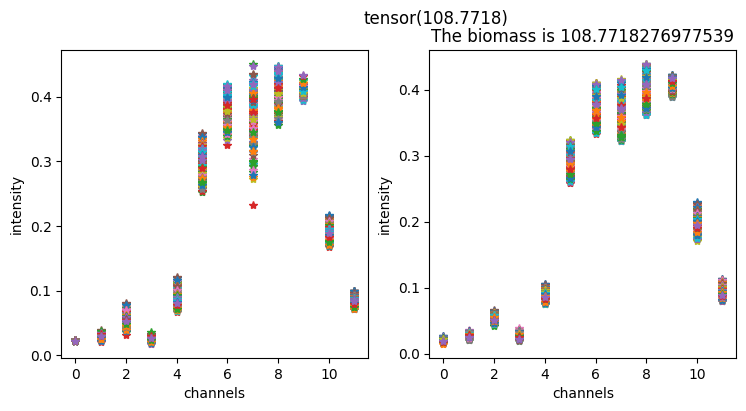

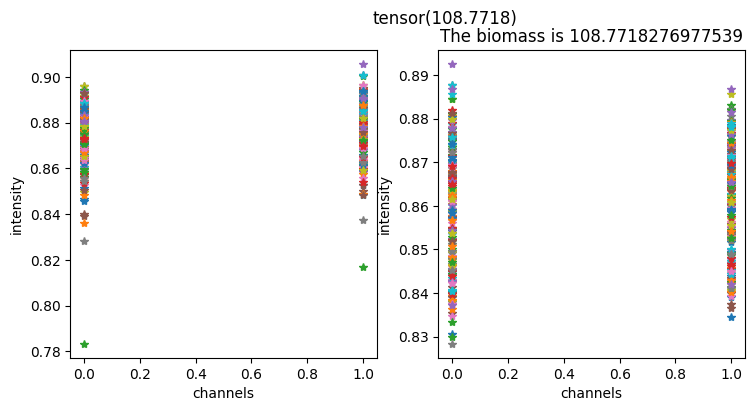

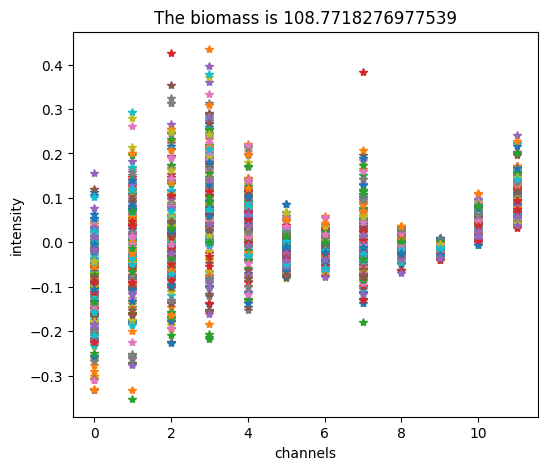

0.30455804


In [ ]:

total_loss = 0
total_samples = 0
for data in test_loader:
    inputs, labels = data
    # outputs =conv_deconv(inputs)
    features, pool_size = conv(inputs)
    outputs = deconv(features, pool_size )
      
    for l in range(10):

        # imgi = inputs[l].permute(1,2,0) 
        imgi = inputs[l].detach().numpy()
        imgi_ndvi = imgi[12:14,:]
        imgi_lswi = imgi[14,:]
        imgi = imgi[0:12,:]
        # print(imgi.size())

        # imgo = outputs[l].permute(1,2,0)
        # print(imgo.size())
        #imgi = imgi[:,:,2:5]
        imgo = outputs[l].detach().numpy()
        imgo_ndvi = imgo[12:14,:]
        imgo_lswi = imgo[14,:]
        imgo = imgo[0:12,:]

        img_diff = imgo - imgi
        error = np.sum(np.power(img_diff,2))

        img_diff = img_diff/imgi
        # img_diff =  img_diff / img_diff.max()

        scatter_spectrums([imgi,imgo],labels[l]*500)
        # plot_spectrum(imgo,labels[l]*500)

        scatter_spectrums([imgi_ndvi,imgo_ndvi],labels[l]*500)
        # plot_spectrum(imgo_ndvi,labels[l]*500)
        scatter_spectrum(img_diff,labels[l]*500)
        print(error)

        # fig, axs = plt.subplots(1,3, figsize=(10, 6))
        # fig = plt.gcf()
        # fig.set_size_inches(18.5,10.5)
       
        # img_show = np.array(imgi[:,:,0:3])
        # # m = img_show.max()
        # # img_show = img_show / m
        
        # img_show2 = np.array(imgo[:,:,0:3].detach().numpy())
        # # m = img_show2.max()
        # # img_show2 = img_show2 / m

        # axs[0].imshow(img_show/img_show.max())
        # axs[1].imshow(img_show2/img_show.max())
        # img_diff = (img_show2 - img_show)
        # axs[2].imshow(img_diff/img_diff.max())
        # error = np.sum(np.power(img_diff,2))
        # a = img_diff/img_show
        # axs[3].imshow(a)

        # print(error)
        # # axs[2].title(str(error))
        # plt.show()


      
    break

In [ ]:
from visualization import plot_spectrum
total_loss = 0
total_samples = 0
for data in test_loader:
    inputs, labels = data
    # outputs =conv_deconv(inputs)
    features, pool_size = conv(inputs)
    outputs = deconv(features, pool_size )
      
    for l in range(5):

        # imgi = inputs[l].permute(1,2,0) 
        imgi = inputs[l].detach().numpy()
        # print(imgi.size())

        # imgo = outputs[l].permute(1,2,0)
        # print(imgo.size())
        #imgi = imgi[:,:,2:5]
        imgo = outputs[l].detach().numpy()

        plot_spectrum(imgi,labels[l]*500)
        plot_spectrum(imgo,labels[l]*500)

        img_diff = imgo - imgi
        error = np.sum(np.power(img_diff,2))

        img_diff = img_diff/imgi
        # img_diff =  img_diff / img_diff.max()

        plot_spectrum(img_diff,labels[l]*500)
        print(error)

        # fig, axs = plt.subplots(1,3, figsize=(10, 6))
        # fig = plt.gcf()
        # fig.set_size_inches(18.5,10.5)
       
        # img_show = np.array(imgi[:,:,0:3])
        # # m = img_show.max()
        # # img_show = img_show / m
        
        # img_show2 = np.array(imgo[:,:,0:3].detach().numpy())
        # # m = img_show2.max()
        # # img_show2 = img_show2 / m

        # axs[0].imshow(img_show/img_show.max())
        # axs[1].imshow(img_show2/img_show.max())
        # img_diff = (img_show2 - img_show)
        # axs[2].imshow(img_diff/img_diff.max())
        # error = np.sum(np.power(img_diff,2))
        # a = img_diff/img_show
        # axs[3].imshow(a)

        # print(error)
        # # axs[2].title(str(error))
        # plt.show()


      
    break